# Informe De ML Notebook 1 || Modelo para Predecir Depresión

In [1]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from scipy import stats
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, PowerTransformer
warnings.filterwarnings('ignore')

## Se cargan los datos

In [2]:
datos = pd.read_csv('depression.csv')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Gender                            27901 non-null  object 
 1   Age                               27901 non-null  float64
 2   CGPA                              27901 non-null  float64
 3   Sleep Duration                    27901 non-null  object 
 4   Degree                            27901 non-null  object 
 5   Suicidal Thoughts                 27901 non-null  object 
 6   Work/Study Hours                  27901 non-null  float64
 7   Family History of Mental Illness  27901 non-null  object 
 8   Depression                        27901 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 1.9+ MB


### Se separan los datos de entrenamiento y de prueba

In [10]:
from sklearn.model_selection import train_test_split
N=len(datos)
cTrain=int(N*0.8) # 80% para entrenar y 20% para probar
cTest=N-cTrain
print(N,cTrain,cTest)
train_data,test_data=sklearn.model_selection.train_test_split(datos, train_size=cTrain, test_size=cTest)

27901 22320 5581


### Se grafican los datos para ver su estrucutura y así determinar el método de normalización

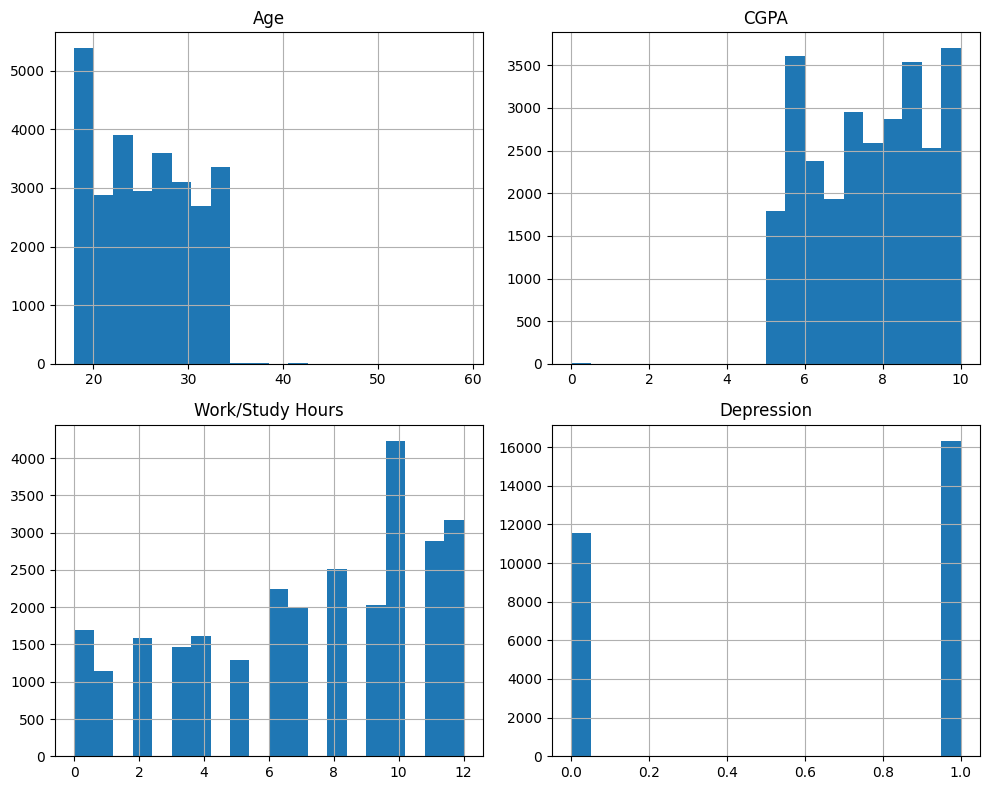

In [4]:
datos.hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()

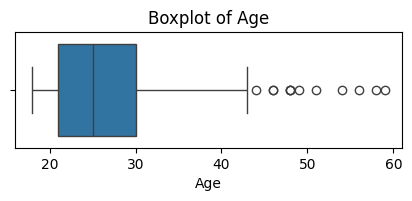

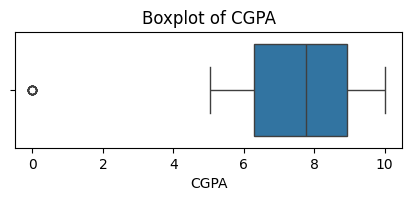

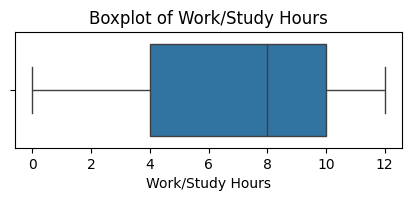

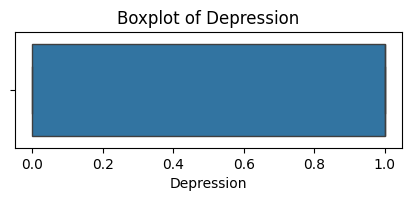

In [5]:
# Gráficos de caja
for col in datos.select_dtypes(include='number').columns:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(data=datos, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

### Análisis de los gráficos:
En los histogramas se puede ver que la edad tiene una asimetría positiva y las horas de estudio tienen una asimetría negativa, el histograma del CGPA también presenta un cierto nivel de asimetría, esto hace que sea mejor utilizar la estrategia de normalización de caja, en este caso "Yeo-Johnson".

Ahora, los diagramas de caja muestran algo interesante con "Age", pues tiene varios datos átipicos, esto hace que la estrategia de normalización MinMax sea la indicada para age.
A la varaible "Depression" se le aplica la estándar la igual que a la de "CGPA, W/S Hours" después de que sean normalizadas con MinMax.


### Datos Categoricos

In [3]:
categorica = ['Gender', 'Sleep Duration', 'Degree', 'Suicidal Thoughts',  'Family History of Mental Illness']

### Datos Númericos clasificados en su respectiva normalizacion

In [6]:
numerica_std = ['Depression']
numerica_box = ['CGPA', 'Work/Study Hours']
numerica_minmax = ['Age']

## Se hace el Pipeline para los datos númericos

In [7]:
numeric_transformer = Pipeline(steps=[
    ('boxcox', PowerTransformer(method='yeo-johnson')),   # transform to normal-like distribution
    ('scaler', StandardScaler())                      # then scale to mean=0, std=1
])

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())

    ])

### Categoricos

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 6 atributos categóricos
cat_attribs = ['calefaccion','consumo_calefacion','desague','vistas_lago','nueva_construccion','aire_acondicionado']

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False))
    ])

## Se hace el Preprocessor con el pipeline númerico y se incluye el OneHotEncoder para el categórico de una vez (Full Pipeline)

In [45]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, numerica_std),
    ("box", numeric_transformer, numerica_box),
    ("min", MinMaxScaler(), numerica_minmax),
    ("cat", cat_pipeline, categorica)
])

In [46]:
X_train = preprocessor.fit_transform(train_data)

In [47]:
X_train.shape

(22320, 20)

Quedan 20 valores para el OneHotEncoder, 4 para los númericos y 16 para los categóricos

In [49]:
y_train = train_data["Depression"] # la función objetivo es depression
y_train

18356    1
3000     0
10747    1
6259     0
22650    0
        ..
15031    1
8560     1
15041    1
16275    1
11500    0
Name: Depression, Length: 22320, dtype: int64

## Entrenamiento de las redes neuronales

### Se crean los cinco modelos variando el tamaño de las redes

In [50]:
modelo1 = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(3,5), random_state=123)
modelo1.fit(X_train, y_train)
scores1 = cross_val_score(modelo1, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores1)
scores1.mean()

[-0.00138154 -0.00155308 -0.00204445 -0.00188059 -0.00165943]


np.float64(-0.0017038189423026421)

In [51]:
modelo2 = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,5), random_state=123)
modelo2.fit(X_train, y_train)
scores2 = cross_val_score(modelo2, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores2)
scores2.mean()

[-0.00199639 -0.0019529  -0.00294667 -0.00191305 -0.00279298]


np.float64(-0.0023203975512640115)

In [52]:
modelo3 = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(3,5,5), random_state=123)
modelo3.fit(X_train, y_train)
scores3 = cross_val_score(modelo3, X_train , y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores3)
scores3.mean()

[-4.21855035e-04 -8.45456927e-05 -2.63582024e-04 -3.88287758e-04
 -7.59553687e-04]


np.float64(-0.0003835648394063572)

In [53]:
modelo4 = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,10), random_state=123)
modelo4.fit(X_train, y_train)
scores4 = cross_val_score(modelo4, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores4)
scores4.mean()

[-0.00250703 -0.00227846 -0.00207012 -0.00225166 -0.0023595 ]


np.float64(-0.002293355437139844)

In [54]:
modelo5 = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=123)
modelo5.fit(X_train, y_train)
scores5 = cross_val_score(modelo5, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores5)
scores5.mean()

[-0.00182579 -0.00203364 -0.00136288 -0.00100978 -0.00165404]


np.float64(-0.0015772254989860391)

### Ahora se usan los modelos con los datos de prueba

In [55]:
X_test = preprocessor.transform(test_data)
X_test

array([[ 0.83963573, -0.39363811, -0.0763353 , ...,  1.        ,
         1.        ,  0.        ],
       [-1.19099267,  1.5887381 , -1.38973053, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.83963573, -0.63544391,  0.48527954, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.83963573,  0.29450584,  1.06151541, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.83963573, -0.10917963, -1.62804227, ...,  1.        ,
         0.        ,  1.        ],
       [-1.19099267,  1.41855035,  1.06151541, ...,  0.        ,
         1.        ,  0.        ]], shape=(5581, 20))

In [56]:
y_pred1 = modelo1.predict(X_test)
y_pred1

array([ 9.99290258e-01, -4.08006163e-04,  9.99331066e-01, ...,
        9.99956044e-01,  1.00091820e+00,  2.10218276e-04], shape=(5581,))

In [57]:
y_pred2 = modelo2.predict(X_test)
y_pred2

array([ 1.00045705e+00,  1.77528646e-04,  1.00104546e+00, ...,
        1.00274548e+00,  9.94831863e-01, -4.63745145e-05], shape=(5581,))

In [58]:
y_pred3 = modelo3.predict(X_test)
y_pred3

array([ 1.00045976e+00,  5.74524250e-04,  1.00144004e+00, ...,
        1.00000789e+00,  9.99679849e-01, -2.62178082e-04], shape=(5581,))

In [59]:
y_pred4 = modelo4.predict(X_test)
y_pred4

array([1.00125436e+00, 1.57257508e-03, 9.98379253e-01, ...,
       9.94822501e-01, 1.00428727e+00, 5.34331041e-04], shape=(5581,))

In [60]:
y_pred5 = modelo5.predict(X_test)
y_pred5

array([ 9.96491111e-01, -3.89110273e-05,  1.00316891e+00, ...,
        9.99746889e-01,  1.00386345e+00, -3.89110273e-05], shape=(5581,))

In [61]:
y_test = test_data["Depression"]
y_test

11359    1
10024    0
12516    1
8627     0
17402    1
        ..
2334     0
10062    0
6714     1
19011    1
4048     0
Name: Depression, Length: 5581, dtype: int64

### ya con estas variables se puede calcular que tan acertado es cada modelo (Accuracy)

In [62]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_pred1
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.18%
Approximate Accuracy: 99.82%


In [63]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_pred2
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.36%
Approximate Accuracy: 99.64%


In [64]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_pred3
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.10%
Approximate Accuracy: 99.90%


In [65]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_pred4
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.36%
Approximate Accuracy: 99.64%


In [40]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_pred5
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.44%
Approximate Accuracy: 99.56%


In [68]:
import pandas as pd

# Example data
models = ['Model 1', 'Model 2','Model 3', 'Model 4', 'Model 5']
metrics = ['MAE', 'RMSE', 'R²']

# Results: each sublist corresponds to one model's metrics
results = [
    [99.82, 99.64, 99.90, 99.64, 99.56],  # Model 1
]

# Create the DataFrame
df = pd.DataFrame(results, columns=models, )

# Display the table
df

,Model 1,Model 2,Model 3,Model 4,Model 5
0,99.82,99.64,99.9,99.64,99.56


el modelo más preciso es el 3

## Variaciones de los hiperparámetros

para esto se usará el modelo 3

se usará el solver adam

In [70]:
modelo3_v1 = MLPRegressor(activation='relu',solver='adam', alpha=1e-5,hidden_layer_sizes=(3,5,5), random_state=123)
modelo3_v1.fit(X_train, y_train)
scores3 = cross_val_score(modelo3_v1, X_train , y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores3)
scores3.mean()

[-0.00163141 -0.00188944 -0.00174429 -0.00120204 -0.00156202]


np.float64(-0.0016058413897464402)

accuracy:

In [71]:
y_predv1 = modelo3_v1.predict(X_test)
y_predv1

array([ 0.99943002, -0.00226941,  1.00065846, ...,  0.99950838,
        0.99908853, -0.00157999], shape=(5581,))

In [72]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_predv1
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.10%
Approximate Accuracy: 99.90%


Se mantuvo igual

In [73]:
modelo3_v2 = MLPRegressor(activation='logistic',solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(3,5,5), random_state=123)
modelo3_v2.fit(X_train, y_train)
scores3 = cross_val_score(modelo3_v2, X_train , y_train, cv=5, scoring='neg_mean_absolute_error')
print(scores3)
scores3.mean()

[-0.00284018 -0.00351778 -0.0032907  -0.00302222 -0.00284426]


np.float64(-0.0031030266073352503)

In [74]:
y_predv2 = modelo3_v2.predict(X_test)
y_predv2

array([ 1.00288103, -0.00514696,  1.00206486, ...,  0.9993015 ,
        0.99760964, -0.00423102], shape=(5581,))

In [75]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred  = y_predv2
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred[mask]
mape = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")

MAPE: 0.19%
Approximate Accuracy: 99.81%


empeoró un poco

Los resultados no varían cuando cambia el solver debido a que no son tan diferentes, especialmente para el tamaño de los datos,logistic puede estar dando resultados un poco menos acertados debido a su enfoque de datos.